In [24]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  #Comment out if you want to use GPUs
import mlc_func as mlcf
import numpy as np
import pandas as pd
import os
import shutil
basedir = os.getcwd() + '/'

for dir_ in ['md_1','md_mixing/','model/']:
    try:
        shutil.rmtree(dir_)
    except FileNotFoundError:
        pass
    os.mkdir(dir_)
    
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Training a force model

Create a file containing the target forces. The example datasets were created with two DFT calculations using 
single zeta and double zeta polarized basis set respectively. The forces are saved as CSV files.

In [25]:
# Load force files    
force_sz = np.genfromtxt(basedir + 'data/monomers.forces_sz', delimiter = ',')
force_dz = np.genfromtxt(basedir + 'data/monomers.forces_dz', delimiter = ',')

# Targets: Reference - Baseline
force_targets = force_dz - force_sz

# Save targets in file
pd.DataFrame(force_targets).to_csv(basedir + 'data/monomers.forces_targets', index = None, header = None)

Now create a force MLCF by passing it the relevant datasets

In [26]:
# An overview of the functionality can be obtained by running:
mlcf.ml.build_force_mlcf?

In [27]:
# List of files that contain the features (input data)
feature_src = [basedir + 'data/monomers_processed.hdf5']

# List of files that contain the targets 
target_src = [basedir + 'data/monomers.forces_targets']
 
# List of file containing the system coordinates (should be either .traj or .xyz file)
traj_src = [basedir + 'data/monomers.traj']

In [28]:
# By setting species = 'o' we tell build_force_mlcf that we would like to train a model for Oxygen
nn = mlcf.ml.build_force_mlcf(feature_src, target_src, traj_src, species = 'o')

{'r_o_o': 1.0, 'r_i_o': 0.05, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'nn'}
(782, 18)


The printout shows the basis sets used to create the descriptors (electronic fingerprints).
Let's start training the model ...

In [29]:
nn.train(max_epochs = 10001)

--------Epoch = 0----------
Training loss || Validation loss
     3.803049 ||      3.680466
--------Epoch = 500----------
Training loss || Validation loss
     1.177038 ||      1.127680
--------Epoch = 1000----------
Training loss || Validation loss
     0.697051 ||      0.652562
--------Epoch = 1500----------
Training loss || Validation loss
     0.635562 ||      0.567683
--------Epoch = 2000----------
Training loss || Validation loss
     0.588061 ||      0.508856
--------Epoch = 2500----------
Training loss || Validation loss
     0.512261 ||      0.429642
--------Epoch = 3000----------
Training loss || Validation loss
     0.374366 ||      0.312931
--------Epoch = 3500----------
Training loss || Validation loss
     0.274246 ||      0.228562
--------Epoch = 4000----------
Training loss || Validation loss
     0.221526 ||      0.187139
--------Epoch = 4500----------
Training loss || Validation loss
     0.178976 ||      0.153257
--------Epoch = 5000----------
Training loss || Valida

If we see that the model overfits (indicated by a high validation loss) we can set a regularization parameter `b`. We can also set `early stopping = True` so that the model stops fitting as soon as the validation loss increases

In [30]:
nn.train(max_epochs = 20001, early_stopping = True, b=1e-7, restart = True, epochs_per_output=2000)

--------Epoch = 0----------
Training loss || Validation loss
     3.484428 ||      3.346528
--------Epoch = 2000----------
Training loss || Validation loss
     0.286622 ||      0.231721
--------Epoch = 4000----------
Training loss || Validation loss
     0.091599 ||      0.095973
--------Epoch = 6000----------
Training loss || Validation loss
     0.034877 ||      0.042756
--------Epoch = 8000----------
Training loss || Validation loss
     0.021142 ||      0.027745
--------Epoch = 10000----------
Training loss || Validation loss
     0.015195 ||      0.020601
--------Epoch = 12000----------
Training loss || Validation loss
     0.012176 ||      0.016527
--------Epoch = 14000----------
Training loss || Validation loss
     0.010761 ||      0.014309
--------Epoch = 16000----------
Training loss || Validation loss
     0.010074 ||      0.013205
--------Epoch = 18000----------
Training loss || Validation loss
     0.009667 ||      0.012580


After fitting the model we can check its performance on the test set, if we're happy we can save the model to disk 

======== Evaluation on test set =============
              RMSE =  0.0126
              MAE = 0.0074
              Max. abs. error = 0.1036


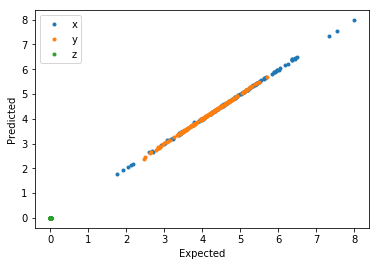

{'rmse': 0.012611578112854125,
 'mae': 0.00739186942060802,
 'max': 0.10360413093566878}

In [31]:
nn.evaluate(plot=True, on = 'test')

In [32]:
nn.save_all(basedir + 'model/')

Let's do the same for Hydrogen. We set `autofilt_percent = 0.005` to disregard the 0.5 percentile of the dataset (on both ends of the distribution) to disregard outliers and improve fitting performance. 

In [33]:
nn = mlcf.ml.build_force_mlcf(feature_src, target_src, traj_src, species = 'h', autofilt_percent= 0.005)
nn.train(max_epochs = 20001, early_stopping = True, b=1e-7, restart = True, epochs_per_output=2000)

{'r_o_o': 1.0, 'r_i_o': 0.05, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'nn'}
(1564, 8)
--------Epoch = 0----------
Training loss || Validation loss
     3.432513 ||      3.450981
--------Epoch = 2000----------
Training loss || Validation loss
     0.252985 ||      0.267868
--------Epoch = 4000----------
Training loss || Validation loss
     0.139672 ||      0.156346
--------Epoch = 6000----------
Training loss || Validation loss
     0.058371 ||      0.064276
--------Epoch = 8000----------
Training loss || Validation loss
     0.038112 ||      0.043980
--------Epoch = 10000----------
Training loss || Validation loss
     0.029178 ||      0.036658
--------Epoch = 12000----------
Training loss || Validation loss
     0.024510 ||      0.032484
--------Epoch = 14000----------
Training loss || Validation loss
     0.021779 ||      0.030149
--------Epoch = 16000----------
Training loss || Validation loss
     0.0

======== Evaluation on test set =============
              RMSE =  0.0280
              MAE = 0.0100
              Max. abs. error = 0.4022


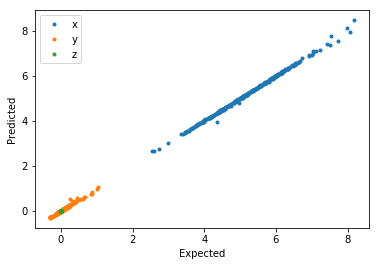

{'rmse': 0.028023226957260592,
 'mae': 0.009972535430641534,
 'max': 0.4022463883972156}

In [34]:
nn.evaluate(plot=True, on = 'test')

In [35]:
nn.save_all(basedir + 'model/')

# Molecular dynamics

Now that the model is trained we can run a molecular dynamics simulation by making use of the ASE package

In [36]:
# Set environment variables for running siesta with ASE
os.environ['SIESTA_PP_PATH'] = basedir + 'psf/' # Pseudopotentials
os.environ['SIESTA_COMMAND'] = 'siesta < ./%s > ./%s' # Siesta command

from ase import Atoms
from ase.md import VelocityVerlet
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.io import read,write, Trajectory
from ase import io
from ase import units as ase_units
from ase.md import logger
from ase.visualize import view

# Starting configuration
atoms = read(basedir + 'data/monomers.traj')

# Give the atoms some momentum 
MaxwellBoltzmannDistribution(atoms, temp=500*ase_units.kB)
momenta = atoms.get_momenta()
# Subtract mean momentum
atoms.set_momenta(momenta - np.mean(momenta, axis = 0))

## Loading the calculator

The calculator is specified in .inp files. These files contain a (keyword, value) pair that are separted by
whitespace. Lines starting with # are ignored

In [37]:
print('Input 1 \n----')
! cat ./md_1.calc
print('Input 2 \n----')
! cat ./md_mixing.calc

Input 1 
----
# Location fo the MLCF model
model ../model/

# Basis set for SIESTA calculations (sz=Single zeta basis)
basis SZ

# XC-functional for SIESTA calculations
xcfunctional PBE

Input 2 
----

# Enable mixing ( n-1 fast steps with alternate with 1 slow step)
mixing True

%block mixing
# Basis, xc-functional and MLCF model used for fast steps
basis1 sz
xcfunctional1 PBE
model1 ../model/

# Basis, xc-functional and MLCF model used for slow steps
# dz_custom is a double zeta polarized basis set optimized for water
basis2 dz_custom 
xcfunctional2 PBE

# Mixing period
n 10
%endblock mixing


In [16]:
try:
    os.chdir(basedir + 'md_1')
except FileNotFoundError:
    pass

traj = io.Trajectory(basedir + 'md_1/md_1.traj',
                         mode = 'w', atoms = atoms)

# ========= The calculator can be loaded by invoking the following command ==============
calculator = mlcf.calculator.load_from_file(basedir + 'md_1.calc')
atoms.calc = calculator
dyn = VelocityVerlet(atoms, dt=0.5*ase_units.fs, logfile= basedir + 'md_1/md_1.log', trajectory = traj)

(solutionmethod, diagon)
(basis, sz)
(xcfunctional, pbe)
(model, ../model/)
(mixing, False)
(cmcorrection, False)
(ipp_client, None)


## Run MD

In [38]:
dyn.run(5) #Feel free to interrupt kernel if it's taking too long
view(read('md_1.traj', ':'))

Using force correction
Using force correction
Using force correction


KeyboardInterrupt: 

## Mixing

One can also use the mixing scheme defined in (?)

In [39]:
# Starting configuration
os.chdir(basedir)
atoms = read(basedir + 'data/monomers.traj')

# Give the atoms some momentum 
MaxwellBoltzmannDistribution(atoms, temp=500*ase_units.kB)
momenta = atoms.get_momenta()
# Subtract mean momentum
atoms.set_momenta(momenta - np.mean(momenta, axis = 0))

try:
    os.chdir('./md_mixing/')
except FileNotFoundError:
    pass

traj = io.Trajectory(basedir + 'md_mixing/md_mixing.traj',
                         mode = 'w', atoms = atoms)

# ========= The calculator can be loaded by invoking the following command ==============
calculator = mlcf.calculator.load_from_file(basedir + 'md_mixing.calc')
atoms.calc = calculator
dyn = VelocityVerlet(atoms, dt=0.5*ase_units.fs, logfile=basedir + 'md_mixing/md_mixing.log', trajectory = traj)
dyn.run(20)
view(read('md_mixing.traj', ':'))

(solutionmethod, diagon)
(basis, dz_custom)
(xcfunctional, bh)
(model, None)
(mixing, True)
(cmcorrection, False)
(ipp_client, None)
(model1, ../model/)
(model2, None)
(basis1, sz)
(basis2, dz_custom)
(xcfunctional1, pbe)
(xcfunctional2, pbe)
(solutionmethod1, diagon)
(solutionmethod2, diagon)
(n, 10)
(cmcorrection1, False)
(cmcorrection2, False)
(which, )
Using force correction


KeyboardInterrupt: 

In [40]:
os.chdir(basedir)
shutil.rmtree('md_1/')
shutil.rmtree('md_mixing/')
shutil.rmtree('model/')